In [ ]:
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
fname = "../sample/xweo_regularity.vhdr"
raw = mne.io.read_raw_brainvision(fname, preload=True)

In [1]:
from pathlib import Path
from mne.io import read_raw_brainvision
from mne.channels import make_standard_montage
from mne import (
                set_log_level,
                Report,
                events_from_annotations,
                Epochs
                )
from mne.viz import plot_projs_joint
from mne.preprocessing import (
                                ICA,
                                create_eog_epochs,
                                compute_proj_eog,
                                find_bad_channels_lof
                                )
import matplotlib.pyplot as plt

Extracting parameters from /Volumes/G_USZ_ORL$/Research/ANTINOMICS/data/eeg/asjt_regularity.vhdr...
Setting channel info structure...
Reading 0 ... 2186059  =      0.000 ...  2186.059 secs...


/var/folders/20/hsy69tx529ndn3rkv5gzcf0c0000gn/T/ipykernel_3825/69548717.py:41: RuntimeWarning: No coordinate information found for channels ['X', 'Y', 'Z', 'Photo', 'Audio']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(fname, preload=True)
/var/folders/20/hsy69tx529ndn3rkv5gzcf0c0000gn/T/ipykernel_3825/69548717.py:41: RuntimeWarning: Not setting positions of 8 misc channels found in montage:
['Pulse', 'GSR', 'X', 'Y', 'Z', 'Resp', 'Photo', 'Audio']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(fname, preload=True)
/var/folders/20/hsy69tx529ndn3rkv5gzcf0c0000gn/T/ipykernel_3825/69548717.py:42: RuntimeWarning: The unit for channel(s) Audio, Pulse, Resp has changed from NA to V.
  raw.set_channel_types(ch_types)


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15'), np.str_('Stimulus/S 16'), np.str_('Stimulus/S 17'), np.str_('Stimulus/S 18')]


/var/folders/20/hsy69tx529ndn3rkv5gzcf0c0000gn/T/ipykernel_3825/69548717.py:44: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['O1', 'O2', 'PO7', 'PO8']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage=montage, match_case=False, on_missing="warn")


LOF: Detected bad channel(s): ['FT9', 'CP1', 'FC3']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 56 sensor positions
Interpolating 3 sensors
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 33001 samples (33.001 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Using EOG channels: PO7, PO8
EOG channel index for this 

NameError: name 'subject_id' is not defined

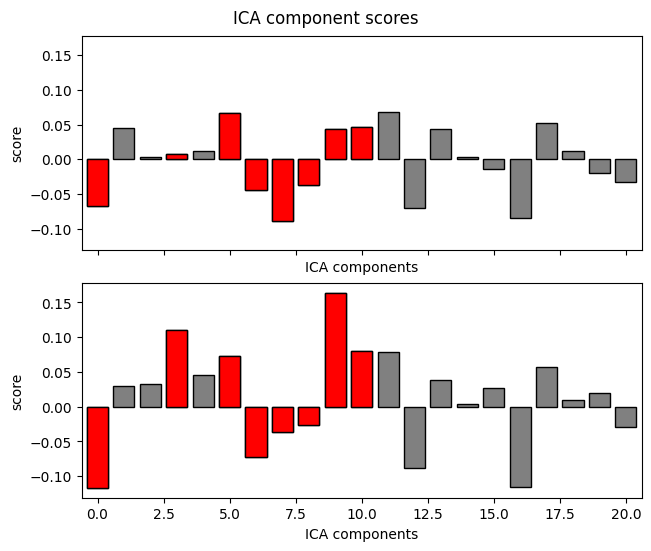

In [ ]:
## extracting subject IDs
main_dir = Path("/Volumes/G_USZ_ORL$/Research/ANTINOMICS/data/eeg")
saving_dir = Path("/Volumes/Extreme_SSD/payam_data/Tinreg")
paradigm = "regularity"
ch_types = {
            "O1": "eog",
            "O2": "eog",
            "PO7": "eog",
            "PO8": "eog",
            "Pulse": "ecg",
            "Resp": "ecg",
            "Audio": "stim"
        }
eog_chs_1 = ["PO7", "PO8"]
eog_chs_2 = ["O1", "O2"]
manual_data_scroll = False
montage = make_standard_montage("easycap-M1")


subjects = []
for fname in sorted(main_dir.iterdir()):
    if str(fname).endswith(f"{paradigm}.vhdr"):
        subjects.append(fname.stem.split("_")[0])

subjects_to_remove = {"vuio", "nrjq"}
subjects = [x for x in subjects if x not in subjects_to_remove]

## reading and preprocessing the files
for subject in subjects[:1]:
    
    ## check paths
    ep_dir = saving_dir / "epochs"
    re_dir = saving_dir / "reports"
    [sel_dir.mkdir(exist_ok=True) for sel_dir in [ep_dir, re_dir]]
    ep_fname = ep_dir / f"{subject}-epo.fif.gz"
    re_fname = re_dir / f"{subject}-report.html" 
    if ep_fname.exists():
        continue

    fname = main_dir / f"{subject}_{paradigm}.vhdr"
    raw = read_raw_brainvision(fname, preload=True)
    raw.set_channel_types(ch_types)
    raw.pick(["eeg", "eog", "ecg", "stim"])
    raw.set_montage(montage=montage, match_case=False, on_missing="warn")
    events, events_dict = events_from_annotations(raw)

    if raw.info["sfreq"] > 1000.0:
        print("resampling to 1000 ...")
        raw, events = raw.resample(1000, stim_picks=None, events=events)

    noisy_chs, lof_scores = find_bad_channels_lof(raw, threshold=3, return_scores=True)
    raw.info["bads"] = noisy_chs

    if manual_data_scroll:
        raw.annotations.append(onset=0, duration=0, description="bad_segment")
        raw.plot(duration=20.0, n_channels=80, picks="eeg", scalings=dict(eeg=40e-6), block=True)
    
    if len(raw.info["bads"]):
        raw.interpolate_bads()
    
    ## filtering
    raw.filter(0.1, 30)
    raw.set_eeg_reference("average", projection=False)
    
    ## vertical eye movement
    ev_eog = create_eog_epochs(raw, ch_name=eog_chs_1).average(picks="all")
    ev_eog.apply_baseline((None, None))
    veog_projs, _ = compute_proj_eog(raw, n_eeg=2, reject=None)
    raw.add_proj(veog_projs)
    raw.apply_proj()

    ## horizontal eye movement
    ica = ICA(n_components=0.97, max_iter=800, method='infomax', fit_params=dict(extended=True))        
    ica.fit(raw)
    eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name=eog_chs_2, threshold=1.2)
    eog_indices_fil = [x for x in eog_indices if x <= 10]
    heog_idxs = [eog_idx for eog_idx in eog_indices_fil if eog_scores[0][eog_idx] * eog_scores[1][eog_idx] < 0]
    fig_scores = ica.plot_scores(scores=eog_scores, exclude=eog_indices_fil, show=False)

    if len(heog_idxs) > 0:
        eog_sac_components = ica.plot_properties(raw,
                                                    picks=heog_idxs,
                                                    show=False,
                                                    )
        ica.apply(raw, exclude=heog_idxs)
    
    ## create report
    report = Report(title=f"report_subject_{subject}")
    report.add_raw(raw=raw, title="Recording Info", butterfly=False, psd=True)

    fig_ev_eog, ax = plt.subplots(1, 1, figsize=(7.5, 3))
    ev_eog.plot(picks="PO7", time_unit="ms", titles="", axes=ax)
    ax.set_title("Vertical EOG")
    ax.spines[["right", "top"]].set_visible(False)
    ax.lines[0].set_linewidth(2)
    ax.lines[0].set_color("magenta")
    ev_eog.apply_baseline((None, None))

    fig_eog = ev_eog.plot_joint(picks="eeg", ts_args={"time_unit": "ms"})
    fig_proj = plot_projs_joint(veog_projs, ev_eog, picks_trace="Fp1")

    for fig, title in zip([fig_ev_eog, fig_eog, fig_proj, fig_scores], ["Vertical EOG", "EOG", "EOG Projections", "Scores"]):
        report.add_figure(fig=fig, title=title, image_format="PNG")
    if len(heog_idxs) > 0:
        report.add_figure(fig=eog_sac_components, title="EOG Saccade Components", image_format="PNG")

    ## epoching and saving
    epochs = Epochs(
                        raw,
                        events,
                        events_dict.pop('New Segment/', None),
                        tmin=-1,
                        tmax=1,
                        baseline=(None, 0),
                        preload=True,
                        )
    del raw
    evoked = epochs.average()
    report.add_evokeds(evoked)

    epochs.save(ep_fname, overwrite=True)
    report.save(re_dir / f"{subject}-report.html", open_browser=False, overwrite=True)



99999

In [30]:
events_dict

{np.str_('Stimulus/S  1'): 1,
 np.str_('Stimulus/S  2'): 2,
 np.str_('Stimulus/S  3'): 3,
 np.str_('Stimulus/S  4'): 4,
 np.str_('Stimulus/S  5'): 5,
 np.str_('Stimulus/S  6'): 6,
 np.str_('Stimulus/S  7'): 7,
 np.str_('Stimulus/S  8'): 8,
 np.str_('Stimulus/S 11'): 11,
 np.str_('Stimulus/S 12'): 12,
 np.str_('Stimulus/S 13'): 13,
 np.str_('Stimulus/S 14'): 14,
 np.str_('Stimulus/S 15'): 15,
 np.str_('Stimulus/S 16'): 16,
 np.str_('Stimulus/S 17'): 17,
 np.str_('Stimulus/S 18'): 18}

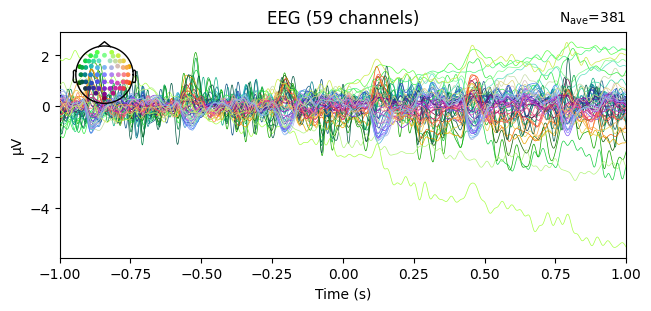

In [25]:
%matplotlib qt
evs[1].plot()

Embedding : jquery-3.6.0.min.js
Embedding : bootstrap.bundle.min.js
Embedding : bootstrap.min.css
Embedding : bootstrap-table/bootstrap-table.min.js
Embedding : bootstrap-table/bootstrap-table.min.css
Embedding : bootstrap-table/bootstrap-table-copy-rows.min.js
Embedding : bootstrap-table/bootstrap-table-export.min.js
Embedding : bootstrap-table/tableExport.min.js
Embedding : bootstrap-icons/bootstrap-icons.mne.min.css
Embedding : highlightjs/highlight.min.js
Embedding : highlightjs/atom-one-dark-reasonable.min.css
Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


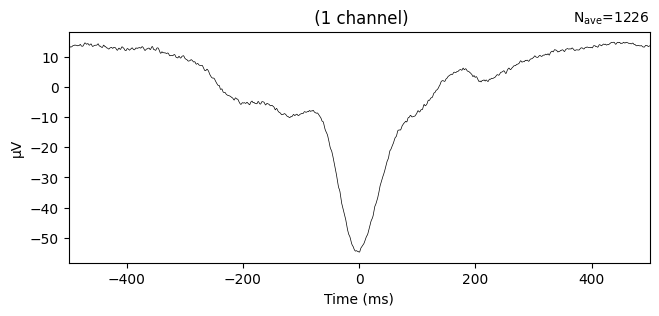

Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.


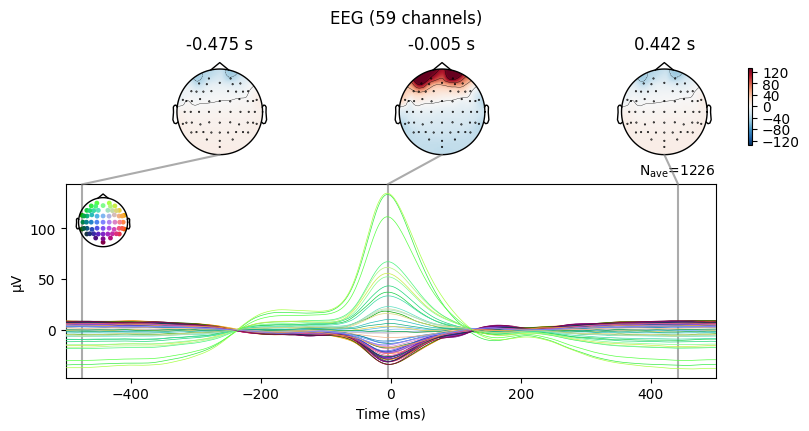

2 projection items deactivated


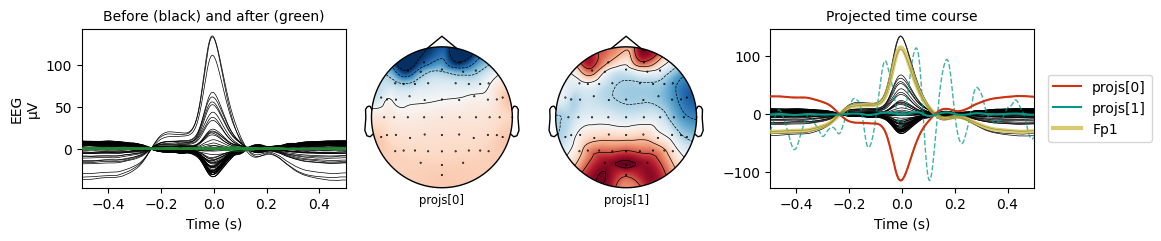

Not setting metadata
6001 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Using data from preloaded Raw for 6001 events and 2001 original time points ...
0 bad epochs dropped
Splitting into 2 parts
Saving report to : /Volumes/Extreme_SSD/payam_data/Tinreg/reports/asjt-report.html


'/Volumes/Extreme_SSD/payam_data/Tinreg/reports/asjt-report.html'

In [3]:
report = Report(title=f"report_subject_{subject}")
report.add_raw(raw=raw, title="Recording Info", butterfly=False, psd=True)

fig_ev_eog, ax = plt.subplots(1, 1, figsize=(7.5, 3))
ev_eog.plot(picks="PO7", time_unit="ms", titles="", axes=ax)
ax.set_title("Vertical EOG")
ax.spines[["right", "top"]].set_visible(False)
ax.lines[0].set_linewidth(2)
ax.lines[0].set_color("magenta")
ev_eog.apply_baseline((None, None))

fig_eog = ev_eog.plot_joint(picks="eeg", ts_args={"time_unit": "ms"})
fig_proj = plot_projs_joint(veog_projs, ev_eog, picks_trace="Fp1")

for fig, title in zip([fig_ev_eog, fig_eog, fig_proj, fig_scores], ["Vertical EOG", "EOG", "EOG Projections", "Scores"]):
    report.add_figure(fig=fig, title=title, image_format="PNG")
if len(heog_idxs) > 0:
    report.add_figure(fig=eog_sac_components, title="EOG Saccade Components", image_format="PNG")

## epoching and saving
epochs = Epochs(
                    raw,
                    events,
                    events_dict,
                    tmin=-1,
                    tmax=1,
                    baseline=(None, 0),
                    preload=True,
                    )
epochs.save(ep_fname, overwrite=True)
report.save(re_dir / f"{subject}-report.html", open_browser=False, overwrite=True)